In [ ]:
import os
import random
import numpy as np
from PIL import Image
import albumentations as A
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model,load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
stage_1 = '/content/drive/MyDrive/Stage1_splitted'
stage_2 = '/content/drive/MyDrive/Stage2_splitted'
stage_3 = '/content/drive/MyDrive/Stage3_splitted'

# MODEL 1 - Crop type Classification

In [ ]:
# Define data directories
train_dir = '/content/drive/MyDrive/Stage1_splitted/train'
test_dir = '/content/drive/MyDrive/Stage1_splitted/test'
val_dir = '/content/drive/MyDrive/Stage1_splitted/val'

In [ ]:
# Define image size and batch size
img_size = (500, 500)
batch_size = 32

In [ ]:
# Create VGG16 base model (pre-trained on ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(500, 500, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a custom top layer for classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

In [ ]:
# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0     

In [ ]:
# Create data generators without augmentation for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 80 images belonging to 3 classes.
Found 10 images belonging to 3 classes.


In [ ]:
# After training, you can print the class indices
print(train_generator.class_indices)

{'Rice_Leaf': 0, 'Sugarcane_Leaf': 1, 'Wheat_Leaf': 2}


In [ ]:
# Train the model
epochs = 20
checkpoint = ModelCheckpoint('/content/drive/MyDrive/vgg16_stage1_model.h5', save_best_only=True)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= 0.75:
            print("\nReached 72% accuracy, so cancelling training!")
            self.model.stop_training = True

# Create the callback
callback = myCallback()

In [ ]:
# Calculate steps_per_epoch for training
steps_per_epoch_train = train_generator.samples // batch_size
if train_generator.samples % batch_size != 0:
    steps_per_epoch_train += 1  # Add 1 if there's a remainder

# Calculate steps_per_epoch for validation
steps_per_epoch_val = val_generator.samples // batch_size
if val_generator.samples % batch_size != 0:
    steps_per_epoch_val += 1  # Add 1 if there's a remainder

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val,
    callbacks=[checkpoint, callback]
)

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 1.1975 - accuracy: 0.3750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 82s 23s/step - loss: 1.1975 - accuracy: 0.3750 - val_loss: 0.8192 - val_accuracy: 0.7000
Epoch 2/20
3/3 [==============================] - 15s 4s/step - loss: 0.9279 - accuracy: 0.5875 - val_loss: 0.6201 - val_accuracy: 0.7000
Epoch 3/20
3/3 [==============================] - 14s 5s/step - loss: 0.6709 - accuracy: 0.7250 - val_loss: 0.6199 - val_accuracy: 0.7000
Epoch 4/20
3/3 [==============================] - 15s 6s/step - loss: 0.6209 - accuracy: 0.7000 - val_loss: 0.5315 - val_accuracy: 0.7000
Epoch 5/20
3/3 [==============================] - 19s 8s/step - loss: 0.5594 - accuracy: 0.6875 - val_loss: 0.4908 - val_accuracy: 0.7000
Epoch 6/20
3/3 [==============================] - 14s 6s/step - loss: 0.5267 - accuracy: 0.6125 - val_loss: 0.4627 - val_accuracy: 0.7000
Epoch 7/20
3/3 [==============================] - 12s 3s/step - loss: 0.4733 - accuracy: 0.7000 - val_loss: 0.5105 - val_accuracy: 0.7000
Epoch 8/20
3/3 [============================

1/1 [==============================] - 2s 2s/step


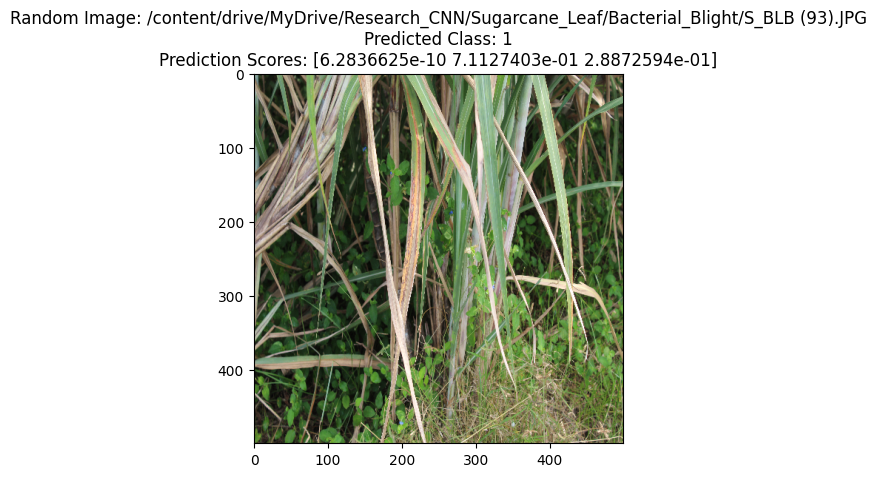

In [ ]:
# Load the trained model
model_path = '/content/drive/MyDrive/vgg16_stage1_model.h5'  # Replace with the actual path to your trained model
loaded_model = load_model(model_path)

# Folder containing the test image
test_image_folder = '/content/drive/MyDrive/Research_CNN/Sugarcane_Leaf/Bacterial_Blight'

# Get a random image from the folder
random_image_filename = random.choice(os.listdir(test_image_folder))
random_image_path = os.path.join(test_image_folder, random_image_filename)

# Load and preprocess the image
img = image.load_img(random_image_path, target_size=(500, 500))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = loaded_model.predict(img_array)

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Display the image and results
plt.imshow(img)
plt.title(f"Random Image: {random_image_path}\nPredicted Class: {predicted_class}\nPrediction Scores: {predictions.flatten()}")
plt.show()

# MODEL 2 -  Diseased vs Non-Diseased Classification

In [ ]:
# Define data directories
train_dir = '/content/drive/MyDrive/Stage2_splitted/train'
test_dir = '/content/drive/MyDrive/Stage2_splitted/test'
val_dir = '/content/drive/MyDrive/Stage2_splitted/val'

In [ ]:
# Create a custom top layer for classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

In [ ]:
# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0   

In [ ]:
# Create data generators without augmentation for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 112 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


In [ ]:
# After training, you can print the class indices
print(train_generator.class_indices)

{'Diseased': 0, 'Non-Diseased': 1}


In [ ]:
# Train the model
epochs = 20
checkpoint = ModelCheckpoint('/content/drive/MyDrive/vgg16_stage2_model.h5', save_best_only=True)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= 0.90:
            print("\nReached 72% accuracy, so cancelling training!")
            self.model.stop_training = True

# Create the callback
callback = myCallback()

In [ ]:
# Calculate steps_per_epoch for training
steps_per_epoch_train = train_generator.samples // batch_size
if train_generator.samples % batch_size != 0:
    steps_per_epoch_train += 1  # Add 1 if there's a remainder

# Calculate steps_per_epoch for validation
steps_per_epoch_val = val_generator.samples // batch_size
if val_generator.samples % batch_size != 0:
    steps_per_epoch_val += 1  # Add 1 if there's a remainder

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val,
    callbacks=[checkpoint, callback]
)

Epoch 1/20
4/4 [==============================] - 76s 18s/step - loss: 0.8252 - accuracy: 0.4554 - val_loss: 0.6710 - val_accuracy: 0.6429
Epoch 2/20
4/4 [==============================] - 15s 4s/step - loss: 0.7282 - accuracy: 0.5089 - val_loss: 0.6828 - val_accuracy: 0.6429
Epoch 3/20
4/4 [==============================] - 15s 4s/step - loss: 0.6538 - accuracy: 0.6339 - val_loss: 0.6715 - val_accuracy: 0.5000
Epoch 4/20
4/4 [==============================] - 17s 4s/step - loss: 0.6504 - accuracy: 0.5446 - val_loss: 0.6611 - val_accuracy: 0.5714
Epoch 5/20
4/4 [==============================] - 15s 4s/step - loss: 0.6356 - accuracy: 0.5982 - val_loss: 0.6338 - val_accuracy: 0.5714
Epoch 6/20
4/4 [==============================] - 15s 3s/step - loss: 0.6272 - accuracy: 0.6518 - val_loss: 0.6348 - val_accuracy: 0.5714
Epoch 7/20
4/4 [==============================] - 14s 4s/step - loss: 0.6111 - accuracy: 0.6429 - val_loss: 0.6510 - val_accuracy: 0.5714
Epoch 8/20
4/4 [=================

1/1 [==============================] - 0s 138ms/step


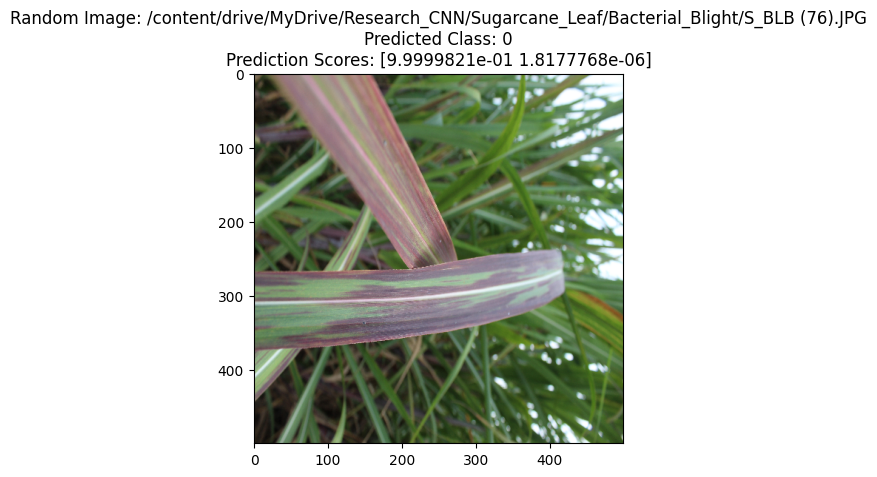

In [ ]:
# Load the trained model
model_path = '/content/drive/MyDrive/vgg16_stage2_model.h5'  # Replace with the actual path to your trained model
loaded_model = load_model(model_path)

# Folder containing the test image
test_image_folder = '/content/drive/MyDrive/Research_CNN/Sugarcane_Leaf/Bacterial_Blight'

# Get a random image from the folder
random_image_filename = random.choice(os.listdir(test_image_folder))
random_image_path = os.path.join(test_image_folder, random_image_filename)

# Load and preprocess the image
img = image.load_img(random_image_path, target_size=(500, 500))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = loaded_model.predict(img_array)

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Display the image and results
plt.imshow(img)
plt.title(f"Random Image: {random_image_path}\nPredicted Class: {predicted_class}\nPrediction Scores: {predictions.flatten()}")
plt.show()

# MODEL 3 - Disease Type Classification

In [ ]:
# Define data directories
train_dir = '/content/drive/MyDrive/Stage3_splitted/train'
test_dir = '/content/drive/MyDrive/Stage3_splitted/test'
val_dir = '/content/drive/MyDrive/Stage3_splitted/val'

In [ ]:
# Create a custom top layer for classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
output = Dense(7, activation='softmax')(x)

In [ ]:
# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 500, 500, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 500, 500, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 250, 250, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 250, 250, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 250, 250, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 125, 125, 128)     0   

In [ ]:
# Create data generators without augmentation for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 56 images belonging to 7 classes.
Found 7 images belonging to 7 classes.


In [ ]:
# After training, you can print the class indices
print(train_generator.class_indices)

{'Bacterial_Leaf_Blight': 0, 'Brownspot': 1, 'Hispa': 2, 'Leafblast': 3, 'Red_Rot': 4, 'Septoria': 5, 'Stripe_Rust': 6}


In [ ]:
# Train the model
epochs = 20
checkpoint = ModelCheckpoint('/content/drive/MyDrive/vgg16_stage3_model.h5', save_best_only=True)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= 0.90:
            print("\nReached 90% accuracy, so cancelling training!")
            self.model.stop_training = True

# Create the callback
callback = myCallback()

In [ ]:
# Calculate steps_per_epoch for training
steps_per_epoch_train = train_generator.samples // batch_size
if train_generator.samples % batch_size != 0:
    steps_per_epoch_train += 1  # Add 1 if there's a remainder

# Calculate steps_per_epoch for validation
steps_per_epoch_val = val_generator.samples // batch_size
if val_generator.samples % batch_size != 0:
    steps_per_epoch_val += 1  # Add 1 if there's a remainder

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val,
    callbacks=[checkpoint, callback]
)

Epoch 1/20
2/2 [==============================] - 49s 43s/step - loss: 2.4592 - accuracy: 0.1250 - val_loss: 1.9643 - val_accuracy: 0.1429
Epoch 2/20
2/2 [==============================] - 8s 3s/step - loss: 1.8385 - accuracy: 0.1250 - val_loss: 1.9144 - val_accuracy: 0.2857
Epoch 3/20
2/2 [==============================] - 8s 4s/step - loss: 1.8847 - accuracy: 0.3036 - val_loss: 1.7075 - val_accuracy: 0.2857
Epoch 4/20
2/2 [==============================] - 8s 3s/step - loss: 1.5870 - accuracy: 0.3214 - val_loss: 1.4502 - val_accuracy: 0.7143
Epoch 5/20
2/2 [==============================] - 8s 4s/step - loss: 1.3328 - accuracy: 0.7321 - val_loss: 1.3700 - val_accuracy: 0.5714
Epoch 6/20
2/2 [==============================] - 8s 5s/step - loss: 1.2610 - accuracy: 0.5179 - val_loss: 1.3329 - val_accuracy: 0.5714
Epoch 7/20
2/2 [==============================] - 7s 4s/step - loss: 1.1433 - accuracy: 0.5536 - val_loss: 1.1387 - val_accuracy: 0.5714
Epoch 8/20
2/2 [=======================

1/1 [==============================] - 0s 148ms/step


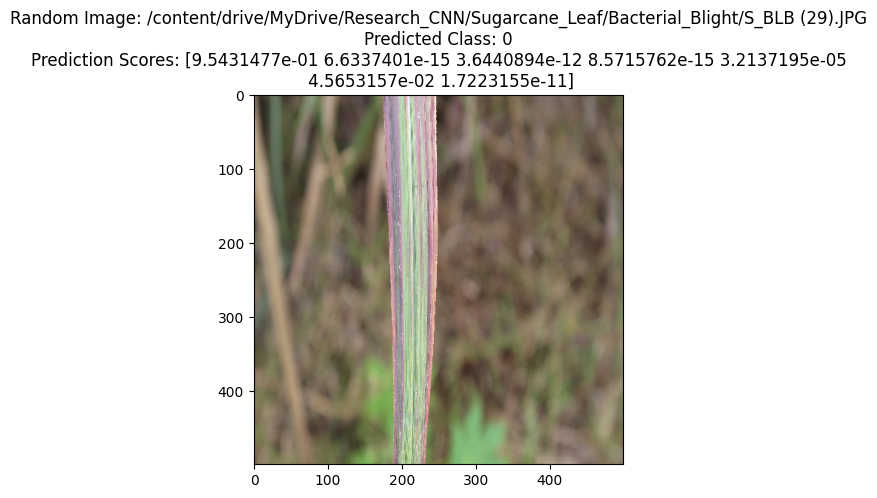

In [ ]:
# Load the trained model
model_path = '/content/drive/MyDrive/vgg16_stage3_model.h5'  # Replace with the actual path to your trained model
loaded_model = load_model(model_path)

# Folder containing the test image
test_image_folder = '/content/drive/MyDrive/Research_CNN/Sugarcane_Leaf/Bacterial_Blight'

# Get a random image from the folder
random_image_filename = random.choice(os.listdir(test_image_folder))
random_image_path = os.path.join(test_image_folder, random_image_filename)

# Load and preprocess the image
img = image.load_img(random_image_path, target_size=(500, 500))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = loaded_model.predict(img_array)

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Display the image and results
plt.imshow(img)
plt.title(f"Random Image: {random_image_path}\nPredicted Class: {predicted_class}\nPrediction Scores: {predictions.flatten()}")
plt.show()